In [1]:
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm as tqdm
import glob
scaler = amp.GradScaler()
device = torch.device('cuda')
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [2]:
DEBUG = False
kernel_type = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'
enet_type = 'efficientnet-b3'
mask_dir = '../../Humpback-Whale-Identification-1st-/input/masks' 
data_dir = '../../train' 
num_workers = 16
image_size = 512
batch_size = 32
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = '../logs_seg'
model_dir = '../models_seg'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [3]:
class SegDataset(Dataset):

    def __init__(self, data,mask_dir,data_dir, mode, transform=None):

        self.data = data
        self.mode = mode
        self.transform = transform
        self.data_dir = data_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data[index]
        image = cv2.imread(os.path.join(self.data_dir,row))[:, :, ::-1]

        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            mask = cv2.imread(os.path.join(self.mask_dir ,row))[:, :, ::-1]
            mask = cv2.resize(mask ,(image_size, image_size)).astype(float)
            mask = (mask > 0.5).astype(np.uint8)[:,:,1:2]
            res = self.transform(image=image, mask=mask)

        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0, 1)
            return torch.tensor(image), torch.tensor(mask)

In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [5]:
dataset_show = SegDataset(os.listdir(f"{mask_dir}"),mask_dir,data_dir, 'train', transform=transforms_train)

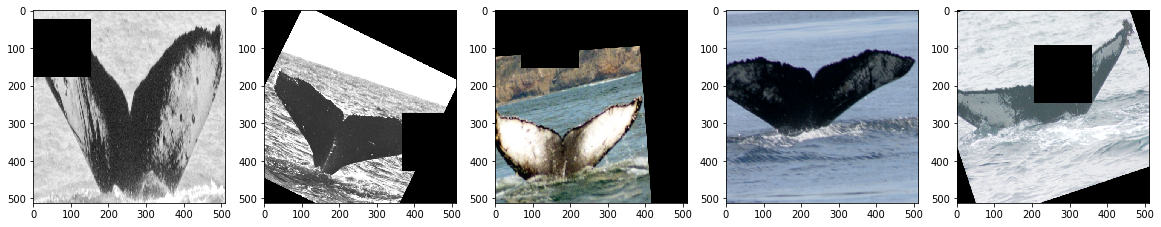

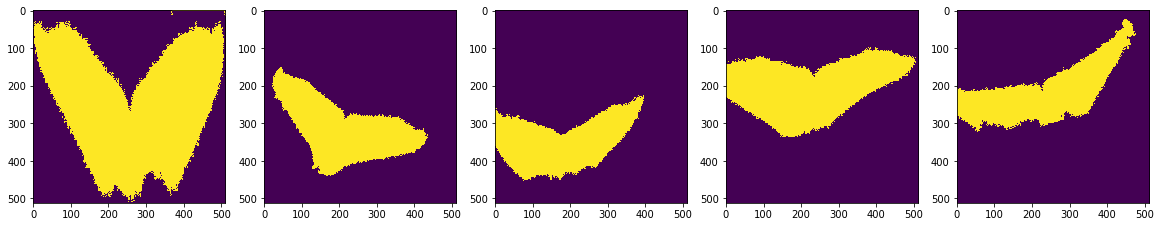

In [6]:
f, axarr = plt.subplots(1,5)
masks = []
for p in range(5):
    img, mask = dataset_show[p]
    img[0] = img[0]
    axarr[p].imshow(img.transpose(0, 1).transpose(1,2))
    masks.append(mask)

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][0])

In [7]:
# !mv efficientnet-b3-5fb5a3c3.pth /home/kaor/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth

In [8]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=1)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features
    
with torch.no_grad():
    m = SegModel(enet_type)
    m(torch.rand(2,3,224,224)).shape

In [10]:
def run(fold):
    content = 'Fold: ' + str(fold)
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    train_ = os.listdir(f"{mask_dir}")
    valid_ = train_[0:50]
    train_ = train_[50:]

    dataset_train = SegDataset(train_,mask_dir,data_dir, 'train', transform=transforms_train)
    dataset_valid = SegDataset(valid_,mask_dir,data_dir, 'valid', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = SegModel(enet_type)
    model = model.to(device)
    val_loss_min = np.Inf
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss = valid_epoch(model, valid_loader)

        content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if val_loss_min > val_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_min = val_loss
    return model

In [11]:
# for fold in range(1):
#     model = run(fold)

In [12]:
df = pd.read_csv("../../whale/bbox/train.csv").fillna('[0]')
df['bbox'] = df['bbox'].map(eval)
df.head(1)

bbox  class           conf  height               image  \
0  [[16, 83, 790, 661]]  whale  [    0.59912]     671  00021adfb725ed.jpg   

             image_id                                         image_path  \
0  00021adfb725ed.jpg  ../input/happy-whale-and-dolphin/train_images/...   

  individual_id                                         label_path  \
0  cadddb1636b9  /kaggle/working/output/train/labels/00021adfb7...   

              species  split  width  
0  melon_headed_whale  Train    804

In [24]:
class TestDataset(Dataset):

    def __init__(self, data,mask_dir,data_dir, mode,csv=None, transform=None):

        self.data = data
        self.mode = mode
        self.transform = transform
        self.data_dir = data_dir
        self.mask_dir = mask_dir
        self.csv = csv

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data[index]
        image = cv2.imread(os.path.join(self.data_dir,row))[:, :, ::-1]
        

        if self.mode == 'test':
            mask = None
            # if self.csv is not None:
            #     if len(self.csv[self.csv.image_id == row])>0:
            #         x0,y0,x1,y1 = self.csv[self.csv.image_id == row]['bbox'].values[0][0]
            #         image = image[int(y0*0.8):int(y1*1.2),int(x0*0.8):int(x1*1.2)] 
            res = self.transform(image=image)
        else:
            mask = cv2.imread(os.path.join(self.mask_dir ,row))[:, :, ::-1]
            mask = cv2.resize(mask ,(image_size, image_size)).astype(float)
            mask = (mask > 0.5).astype(np.uint8)[:,:,1:2]
            res = self.transform(image=image, mask=mask)

        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0, 1)
            return torch.tensor(image), torch.tensor(mask)

In [25]:
df[df.image == '000b8d89c738bd.jpg']

Empty DataFrame
Columns: [bbox, class, conf, height, image, image_id, image_path, individual_id, label_path, species, split, width]
Index: []

In [26]:
dataset_test = TestDataset(os.listdir("../../whale/train_images/"),mask_dir,"../../whale/train_images/", 'test', transform=transforms_val,csv=df)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
dataset_test2 = TestDataset(os.listdir("../../whale/train_images/"),mask_dir,"../../whale/train_images/", 'test', transform=transforms_val,csv=df)
test_loader2 = torch.utils.data.DataLoader(dataset_test2, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
fold = 0
model = SegModel(enet_type)
model = model.to(device)
val_loss_min = np.Inf
model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

  0%|          | 0/1595 [00:00<?, ?it/s]

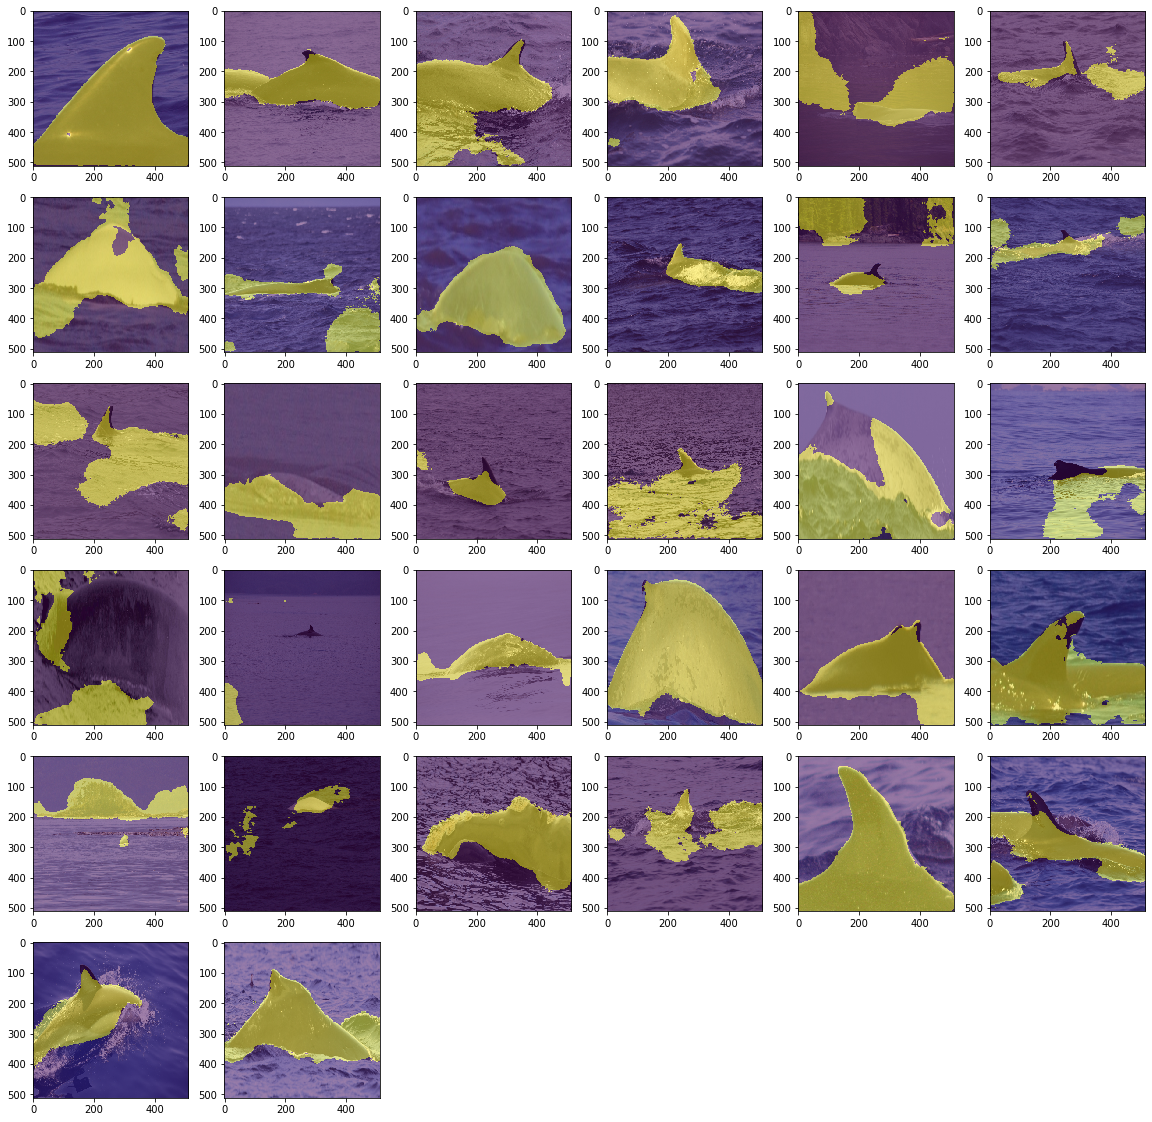

  0%|          | 1/1595 [00:24<10:47:36, 24.38s/it]

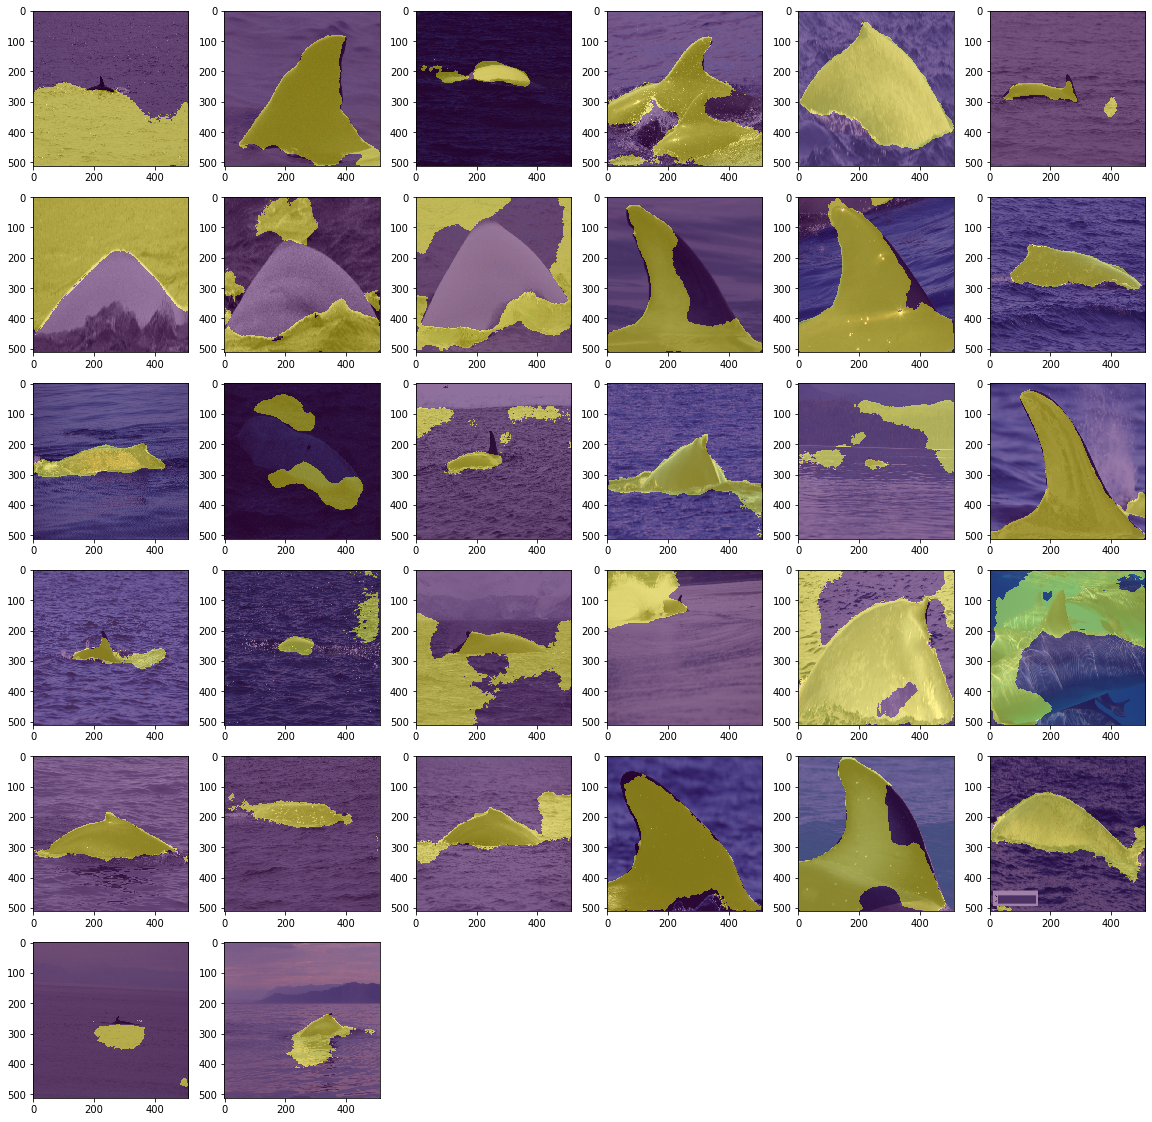

  0%|          | 1/1595 [00:29<12:55:48, 29.20s/it]


In [28]:
with torch.no_grad():
    for j,data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        logits = model(data).sigmoid().cpu().numpy()[:,0]
        data = data.cpu().numpy().transpose(0,2,3,1)
        plt.figure(figsize=[20,20])
        for i,(img,mask) in enumerate(zip(data,logits)):
            plt.subplot(6,6,i+1)
            plt.imshow(img)
            plt.imshow(mask>0.25,alpha=0.5)
        plt.show()
        if j==1:
            break



In [29]:
pseudo_test = TestDataset(os.listdir(data_dir),mask_dir,data_dir, 'test', transform=transforms_val,csv=df)
pseudo_loader = torch.utils.data.DataLoader(pseudo_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
class PseudoSegDataset(Dataset):

    def __init__(self, pseodu_img,pseodu_mask, mode, transform=None):

        self.img = pseodu_img
        self.mask = pseodu_mask
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, index):
        image = self.img[index]

        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            mask = self.mask[index]
            mask = cv2.resize(mask ,(image_size, image_size)).astype(float)
            mask = (mask > 0.2).astype(np.uint8)
            if len(mask.shape)==2:
                mask = np.expand_dims(mask,-1)
            res = self.transform(image=image, mask=mask)

        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0, 1)
            return torch.tensor(image), torch.tensor(mask)

In [31]:
fold=0
model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}_pseudo.pth')

In [32]:
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

  0%|          | 0/793 [00:00<?, ?it/s]

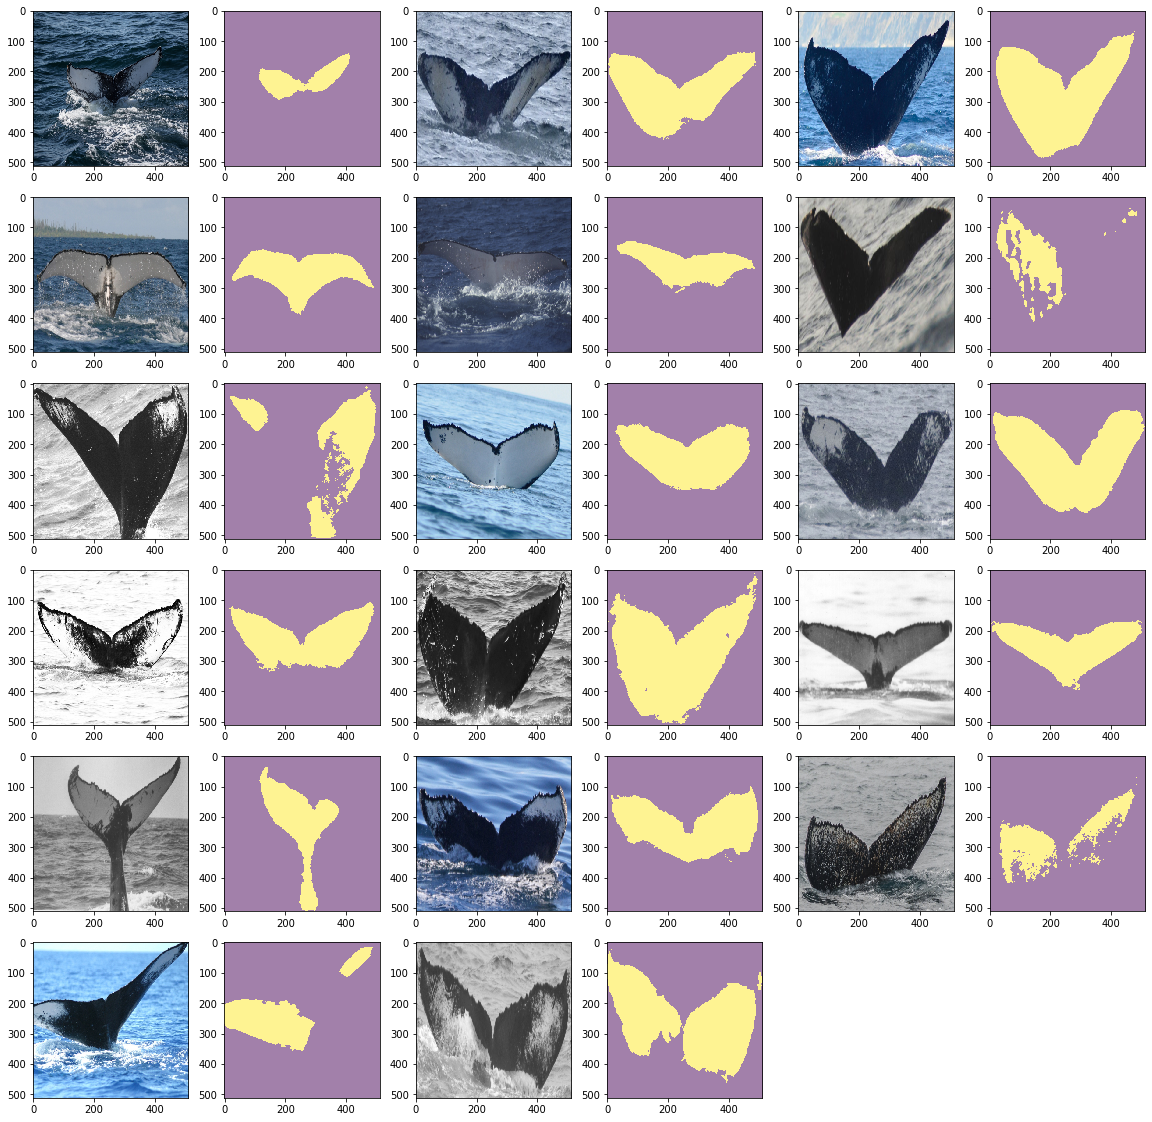

  0%|          | 1/793 [00:07<1:45:32,  8.00s/it]

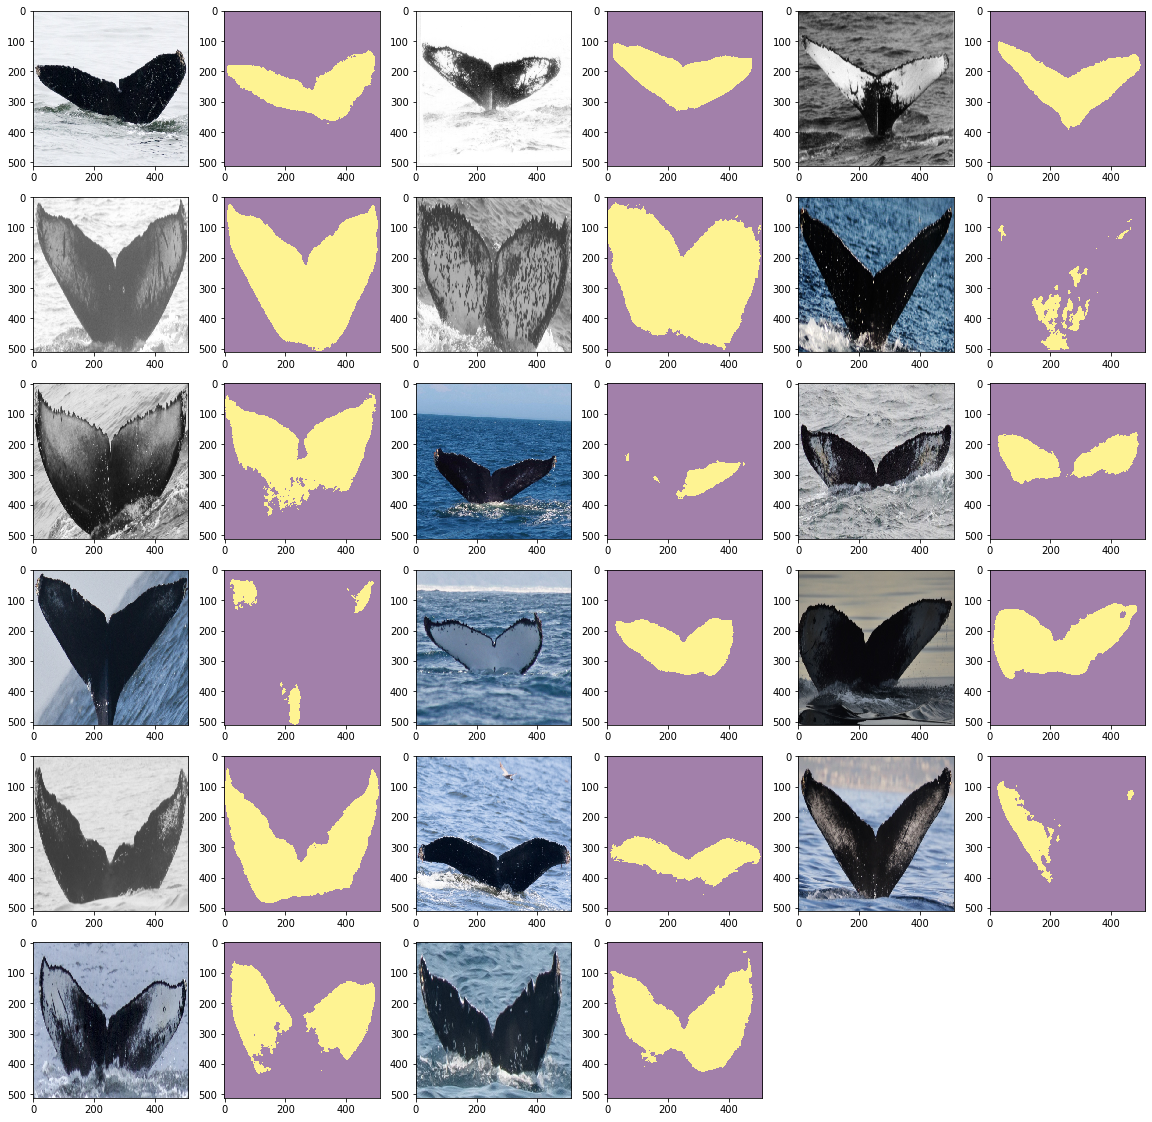

  0%|          | 1/793 [00:12<2:40:47, 12.18s/it]


In [36]:
with torch.no_grad():
    for j,data in enumerate(tqdm(pseudo_loader)):
        data = data.to(device)
        logits = model(data).sigmoid().cpu().numpy()[:,0]
        data = data.cpu().numpy().transpose(0,2,3,1)
        
        plt.figure(figsize=[20,20])
        for i,(img,mask) in enumerate(zip(data,logits)):
            plt.subplot(6,6,i*2+1)
            plt.imshow(img)
            plt.subplot(6,6,(i+1)*2)
            plt.imshow(mask>0.5,alpha=0.5)
            if i==16:
                break
        plt.show()
        if j==1:
            break
